# Import Libraries

In [1]:
import numpy as np
import pandas as pd 
import keras
from keras.layers import Input, Dense, Reshape, Flatten, Dropout,Concatenate
from keras.backend import random_normal,ones_like,zeros_like,mean
from keras.backend import get_session
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import concatenate
from keras.initializers import TruncatedNormal
from keras.callbacks import LearningRateScheduler, EarlyStopping, History
from PIL import Image
import warnings
import os
import time
from glob import glob
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 
from glob import glob
import zipfile


Using TensorFlow backend.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

# Load Images

In [2]:
zip1 = zipfile.ZipFile("../input/Annotation.zip")
zip1.extractall("../working/")
zip2 = zipfile.ZipFile("../input/all-dogs.zip")
zip2.extractall("../working/")

!ls

Annotation  __MACOSX  __notebook__.ipynb  all-dogs


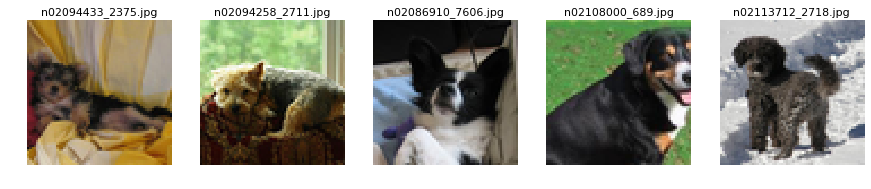

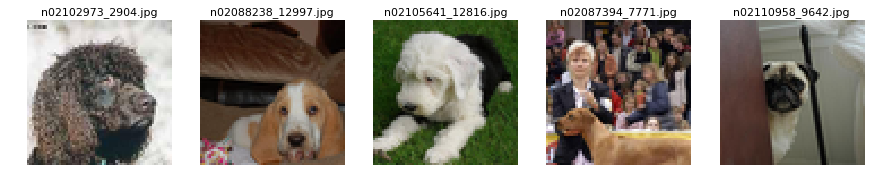

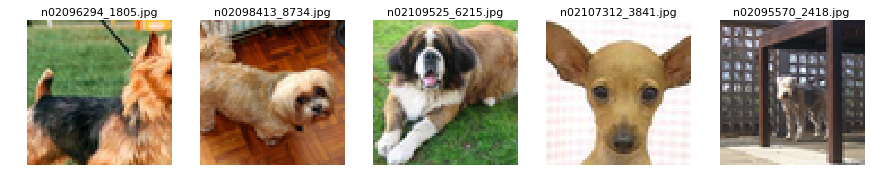

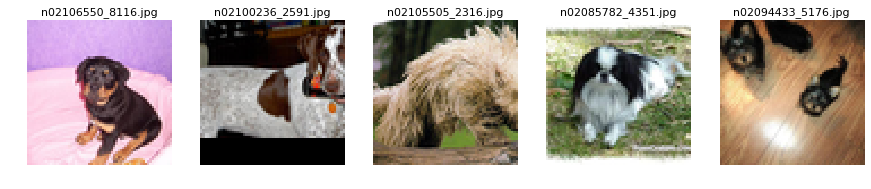

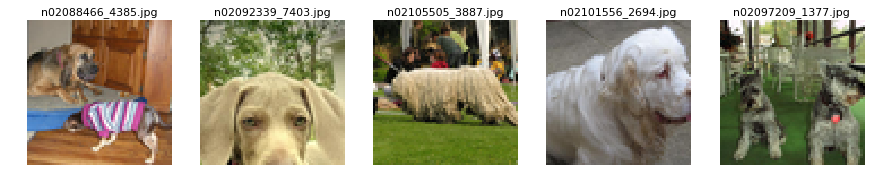

In [3]:
ComputeLB = False
DogsOnly = False

import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET 
import matplotlib.pyplot as plt, zipfile 
from PIL import Image 

ROOT = '../input/generative-dog-images/'
if not ComputeLB: ROOT = '/kaggle/working/'
IMAGES = os.listdir(ROOT + 'all-dogs')
breeds = os.listdir(ROOT + 'Annotation') 

idxIn = 0; namesIn = []
imagesIn = np.zeros((25000,64,64,3))

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
# https://www.kaggle.com/paulorzp/show-annotations-and-breeds
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT+'Annotation/'+breed):
            try: img = Image.open(ROOT+'all-dogs/'+dog+'.jpg') 
            except: continue           
            tree = ET.parse(ROOT+'Annotation/'+breed+'/'+dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin+w, ymin+w))
                img2 = img2.resize((64,64), Image.ANTIALIAS)
                imagesIn[idxIn,:,:,:] = np.asarray(img2)
                #if idxIn%1000==0: print(idxIn)
                namesIn.append(breed)
                idxIn += 1
    idx = np.arange(idxIn)
    np.random.shuffle(idx)
    imagesIn = imagesIn[idx,:,:,:]
    namesIn = np.array(namesIn)[idx]
    
# RANDOMLY CROP FULL IMAGES
else:
    IMAGES = np.sort(IMAGES)
    np.random.seed(810)
    x = np.random.choice(np.arange(20579),10000)
    np.random.seed(None)
    for k in range(len(x)):
        img = Image.open(ROOT + 'all-dogs/' + IMAGES[x[k]])
        w = img.size[0]; h = img.size[1];
        if (k%2==0)|(k%3==0):
            w2 = 100; h2 = int(h/(w/100))
            a = 18; b = 0          
        else:
            a=0; b=0
            if w<h:
                w2 = 64; h2 = int((64/w)*h)
                b = (h2-64)//2
            else:
                h2 = 64; w2 = int((64/h)*w)
                a = (w2-64)//2
        img = img.resize((w2,h2), Image.ANTIALIAS)
        img = img.crop((0+a, 0+b, 64+a, 64+b))    
        imagesIn[idxIn,:,:,:] = np.asarray(img)
        namesIn.append(IMAGES[x[k]])
        #if idxIn%1000==0: print(idxIn)
        idxIn += 1
    
# DISPLAY CROPPED IMAGES
x = np.random.randint(0,idxIn,25)
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        plt.subplot(1,5,j+1)
        img = Image.fromarray( imagesIn[x[k*5+j],:,:,:].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: plt.title(namesIn[x[k*5+j]],fontsize=11)
        else: plt.title(namesIn[x[k*5+j]].split('-')[1],fontsize=11)
        plt.imshow(img)
    plt.show()

# Variables used

In [4]:
IMG_SIZE = Input((12288,))
IMG_SIZE_2 = Input((10000,))
NOISE_SIZE = 10000
BATCH_SIZE = 64

# Build Discriminator

In [5]:
def discriminatorFunction():
    
    input_layer = Dense(12288, activation='sigmoid')(IMG_SIZE_2) 
    input_layer = Reshape((2,12288,1))(concatenate([IMG_SIZE,input_layer]))
    discriminator = Conv2D(filters = 1, kernel_size=[2,1],use_bias=False, name = 'layer_1')(input_layer)
    out = Flatten()(discriminator)
    return out

In [6]:
print("Discriminator")
model = discriminatorFunction()
model_discriminator = Model([IMG_SIZE,IMG_SIZE_2], model)
model_discriminator.get_layer('layer_1').trainable = False
model_discriminator.get_layer('layer_1').set_weights([np.array([[[[-1.0 ]]],[[[1.0]]]])])
model_discriminator.summary()
model_discriminator.compile(optimizer='adam', loss='binary_crossentropy')

Discriminator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 12288)        0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12288)        122892288   input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 24576)        0           input_1[0][0]                    
                                                                 dense_1[0][0]                 

# Build Generator

In [7]:
def GeneratorFunction(noise_shape=(NOISE_SIZE,)):
    input_layer = Input(noise_shape)
    generated = Dense(12288, activation='linear')(input_layer)
        
    model = Model(inputs=input_layer,outputs = [generated,Reshape((10000,))(input_layer)])
    model.summary()
  
    return model

In [8]:
print("Generator")
model_generator = GeneratorFunction(noise_shape=(NOISE_SIZE,))

Generator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12288)        122892288   input_3[0][0]                    
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 10000)        0           input_3[0][0]                    
Total params: 122,892,288
Trainable params: 122,892,288
Non-trainable params: 0
__________________________________________________________________________________________________


# Train the Discriminator

In [9]:
train_y = (imagesIn[:10000,:,:,:]/255.).reshape((-1,12288))
train_X = np.zeros((10000,10000))
for i in range(10000): train_X[i,i] = 1
zeros = np.zeros((10000,12288))

lr = 0.5
for k in range(5):
    LR_Scheduler = LearningRateScheduler(lambda x: lr)
    h = model_discriminator.fit([zeros,train_X], train_y, epochs = 100,batch_size = BATCH_SIZE, callbacks=[LR_Scheduler], verbose=0)
    print('Epoch',(k+1)*10,'/50 - loss =',h.history['loss'][-1] )
    if h.history['loss'][-1]<0.533: lr = 0.1

Epoch 10 /50 - loss = 0.532536421585083
Epoch 20 /50 - loss = 0.5324283012390136
Epoch 30 /50 - loss = 0.5324259362220765
Epoch 40 /50 - loss = 0.5324241882324219
Epoch 50 /50 - loss = 0.5324228425979615


In [10]:
del train_X, train_y, imagesIn

Discriminator Recalls from Memory Dogs


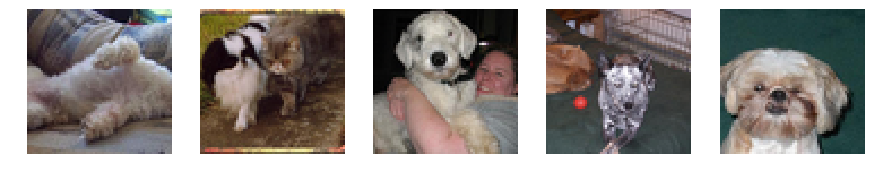

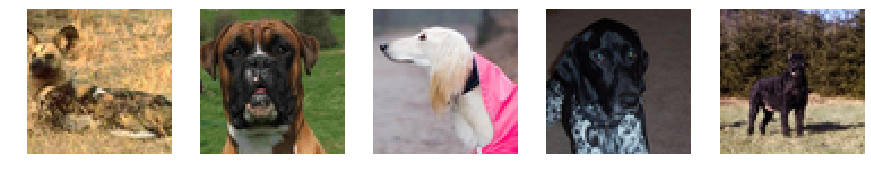

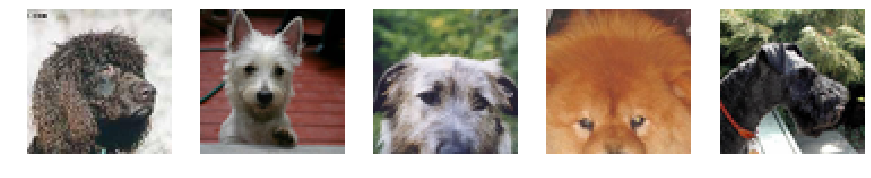

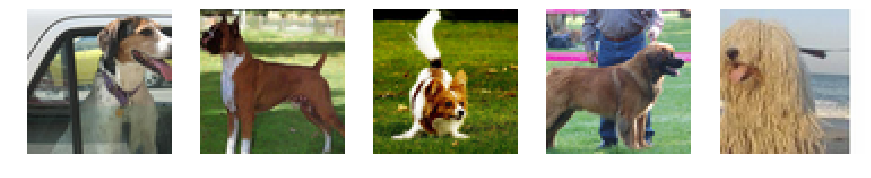

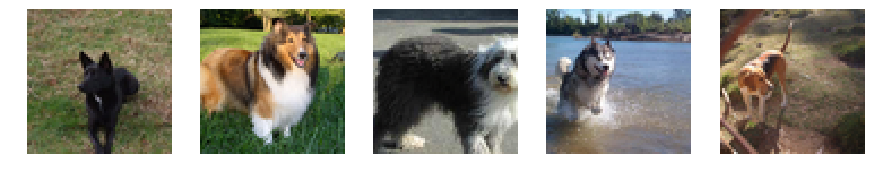

In [11]:
print('Discriminator Recalls from Memory Dogs')    
for k in range(5):
    plt.figure(figsize=(15,3))
    for j in range(5):
        xx = np.zeros((10000))
        xx[np.random.randint(10000)] = 1
        plt.subplot(1,5,j+1)
        img = model_discriminator.predict([zeros[0,:].reshape((-1,12288)),xx.reshape((-1,10000))]).reshape((-1,64,64,3))
        img = Image.fromarray( (255*img).astype('uint8').reshape((64,64,3)))
        plt.axis('off')
        plt.imshow(img)
    plt.show()

# Build the GAN

In [12]:
# BUILD GENERATIVE ADVERSARIAL NETWORK
model_discriminator.trainable = False #discriminator is not trainable for GANs
z = Input(shape=(NOISE_SIZE,))
img = model_generator(z)
real = model_discriminator(img)

# COMPILE GAN
gan = Model(z, real)
gan.get_layer('model_1').get_layer('layer_1').set_weights([np.array([[[[-1 ]]],[[[255.]]]])])
gan.compile(optimizer=Adam(5), loss='mean_squared_error')

# DISPLAY ARCHITECTURE
print("Model created based on Discriminator and Generator")
gan.summary()

Model created based on Discriminator and Generator
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 10000)        0                                            
__________________________________________________________________________________________________
model_2 (Model)                 [(None, 12288), (Non 122892288   input_4[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 12288)        122892290   model_2[1][0]                    
                                                                 model_2[1][1]                    
Total params: 245,784,578
Trainable params: 122,892,288
Non-trainable params: 122,892,290
___________________________________________________________________

# Train the GAN

In [13]:
train = np.zeros((10000,10000))
for i in range(10000): train[i,i] = 1
zeros = np.zeros((10000,12288))

Steps_per_epoch = 30

print("Training begins... Total steps per epoch: {}".format(Steps_per_epoch ))


Training begins... Total steps per epoch: 30


Step: 1/30 [G loss: 6940.2450]


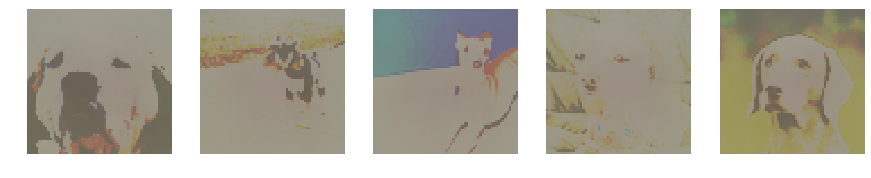

Step: 2/30 [G loss: 2725.7062]


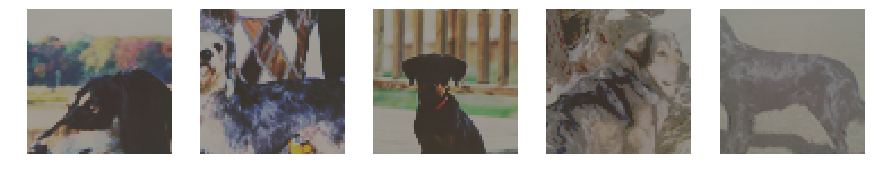

Step: 3/30 [G loss: 1176.6350]


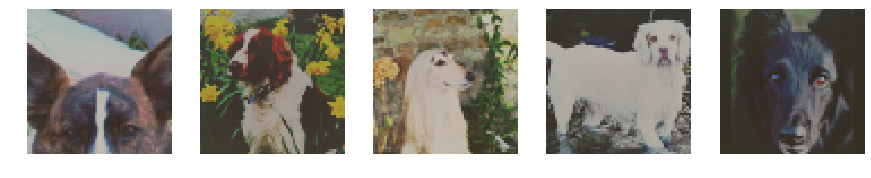

Step: 4/30 [G loss: 500.9212]


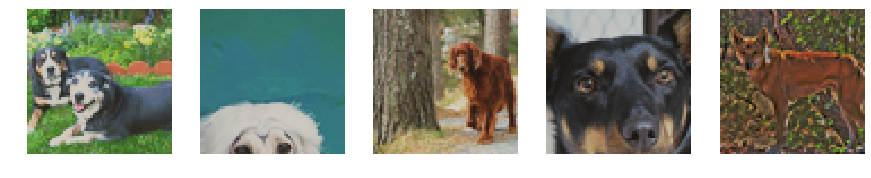

Step: 5/30 [G loss: 210.7294]


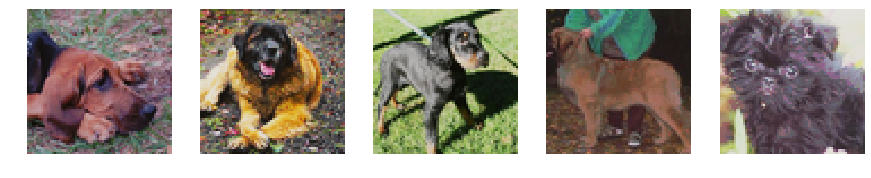

Step: 6/30 [G loss: 93.0484]


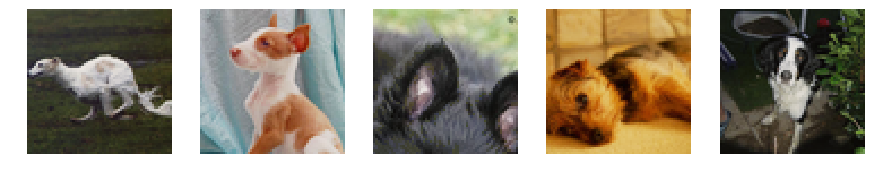

Step: 7/30 [G loss: 46.4607]


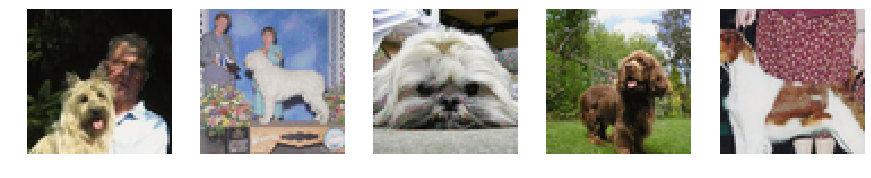

Step: 8/30 [G loss: 29.5200]


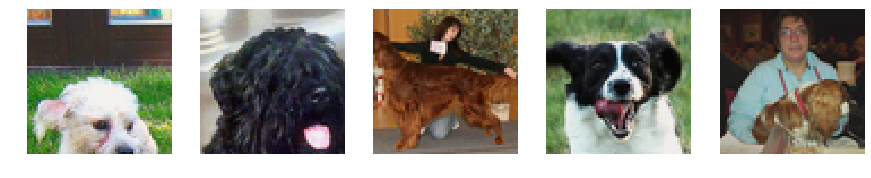

Step: 9/30 [G loss: 24.3648]


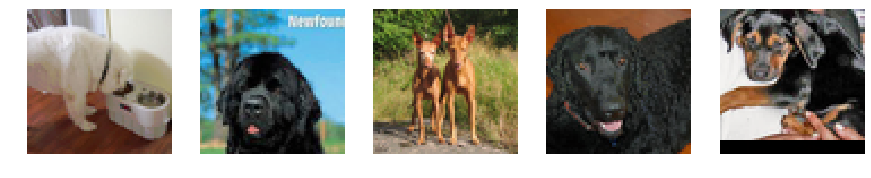

Step: 10/30 [G loss: 16.8836]


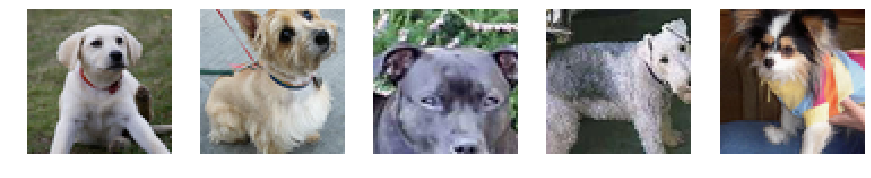

Step: 11/30 [G loss: 8.2068]
Step: 12/30 [G loss: 4.7201]
Step: 13/30 [G loss: 3.4413]
Step: 14/30 [G loss: 2.8259]
Step: 15/30 [G loss: 2.4279]
Step: 16/30 [G loss: 2.1393]
Step: 17/30 [G loss: 1.8920]
Step: 18/30 [G loss: 1.6535]
Step: 19/30 [G loss: 1.4789]
Step: 20/30 [G loss: 1.3535]
Step: 21/30 [G loss: 1.3522]
Step: 22/30 [G loss: 1.3507]
Step: 23/30 [G loss: 1.3492]
Step: 24/30 [G loss: 1.3477]
Step: 25/30 [G loss: 1.3462]
Step: 26/30 [G loss: 1.3446]
Step: 27/30 [G loss: 1.3429]
Step: 28/30 [G loss: 1.3411]
Step: 29/30 [G loss: 1.3394]
Step: 30/30 [G loss: 1.3377]


In [14]:
warnings.filterwarnings("ignore")

lr = 5.

for step in range(Steps_per_epoch):
        
    # ---------------------
    #  Train GAN
    # ---------------------
    LR_Scheduler = LearningRateScheduler(lambda x: lr)
    h = gan.fit(train, zeros, epochs = 1, batch_size=256, callbacks=[LR_Scheduler], verbose=0)

    # DISPLAY GENERATOR LEARNING PROGRESS 
    
    print ("Step: {}/{} [G loss: {:.4f}]".format((step+1), Steps_per_epoch, h.history['loss'][-1]))
        
    if h.history['loss'][-1] < 25: lr = 1.
    #if h.history['loss'][-1] < 1.5: lr = 0.5 # orig
    #if h.history['loss'][-1] < 1.5: lr = 0.05 # test gaves ~7.23
    if h.history['loss'][-1] < 1.5: lr = 0.01 # test gaves ~7.23 
        
    # DISPLAY GENERATOR LEARNING PROGRESS
    
    if step<10: 
    
        # Plot images
        plt.figure(figsize=(15,3))
        for j in range(5):
            zz = np.zeros((10000))
            zz[np.random.randint(10000)] = 1
            plt.subplot(1,5,j+1)
            img = model_generator.predict(zz.reshape((-1,10000)))[0].reshape((-1,64,64,3))
            img = Image.fromarray( (img).astype('uint8').reshape((64,64,3)))
            plt.axis('off')
            plt.imshow(img)
        plt.show()   

# Submit to Kaggle

In [15]:
class DogGenerator:
    index = 0   
    def getDog(self,seed):
        xx = np.zeros((10000))
        xx[self.index] = 0.999
        xx[np.random.randint(10000)] = 0.001
        img = model_generator.predict(xx.reshape((-1,10000)))[0].reshape((64,64,3))
        self.index = (self.index+1)%10000
        return Image.fromarray( img.astype('uint8') ) 

In [16]:
# SAVE TO ZIP FILE NAMED IMAGES.ZIP
z = zipfile.PyZipFile('images.zip', mode='w')
d = DogGenerator()
for k in range(10000):
    img = d.getDog(np.random.normal(0,1,100))
    f = str(k)+'.png'
    img.save(f,'PNG'); z.write(f); os.remove(f)
    #if k % 1000==0: print(k)
z.close()